# TYROLIENNE
This notebook solves the system of ODE required to simulate a bar attached to a zipline sliding along a inclinated cable. It analyses an exam question of the 2022 mechanics I course of Prof. Paolo Ricci.

Author: Antoine Hoffmann

In [10]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
# install scipy if not already installed
try:
    import scipy
except ImportError:
    import pip
    pip.main(['install', 'scipy'])
from scipy.integrate import solve_ivp
from matplotlib.animation import FuncAnimation


## Defining Physical Parameters
Here, we define the physical parameters of the system, such as mass, length, gravity, and initial conditions.

In [ ]:
# Physical parameters
m = 0.1  # mass of the tyrolienne [kg]
l = 1.0  # length of the tyrolienne to CM [m]
g = 9.8  # gravity [m/s^2]
alpha = 0.25 * np.pi / 20  # angle of the cable [rad]
th0 = 3*np.pi / 4  # initial angle of the bar [rad]
om0 = 0  # initial angular velocity of the bar [rad/s]
Ig = m * l**2  # moment of inertia of the bar
eta = Ig / (m * l**2)  # ratio of inertia bar/pendulum
w0 = np.sqrt(g / l)  # natural frequency
T = 2 * np.pi / w0  # period

## Differential Equation
The motion of the tyrolienne is governed by a second-order differential equation: 
```math
\cos\theta \sin^2\theta y'^2 + \sin\theta * (\sin^2\theta + η) y' + (g / l) \cos\alpha \sin^2\theta = 0
```
where $\theta$ is the angle between the tyrolienne and the normal to the cable and $\alpha$ the angle between the cable and the horizontal.

We define these functions and the system of first-order ODEs for numerical integration.

In [ ]:
def F(x):
    return np.cos(alpha + x) * np.sin(alpha + x)**2
def G(x):
    return np.sin(alpha + x) * (np.sin(alpha + x)**2 + eta)
def H(x):
    return g / l * np.cos(alpha) * np.sin(alpha + x)**2
def tyrol(t, y):
    return [y[1], -(F(y[0]) * y[1]**2 + H(y[0])) / G(y[0])]

## Numerical Parameters
We define the time range and step size for the numerical simulation.

In [13]:
# Numerical parameters
Tmax = 5 * T  # maximum simulation time [s]
dt = 1.0e-2  # time step [s]
t_eval = np.arange(0, Tmax, dt)  # time points for evaluation

## Solving the Differential Equation
We use the `solve_ivp` function from `scipy` to solve the differential equation numerically.

In [14]:
# Solve the differential equation using solve_ivp
sol = solve_ivp(tyrol, [0, Tmax], [th0, om0], t_eval=t_eval)

## Post-Processing
We compute the angular acceleration, position, velocity, and energies (potential, kinetic, rotational, and mechanical) of the system.

In [15]:
# Post-processing
theta = sol.y[0]
omega = sol.y[1]
omdot = np.gradient(omega, t_eval)  # angular acceleration
Acc = lambda th, w, wdot: (l * w**2 * np.sin(alpha + th) + g * np.sin(alpha) - l * wdot * np.cos(alpha + th))
xA = np.zeros_like(t_eval)
vA = np.zeros_like(t_eval)
for i in range(1, len(t_eval)):
    dt = t_eval[i] - t_eval[i - 1]
    vA[i] = vA[i - 1] + dt * Acc(theta[i - 1], omega[i - 1], omdot[i - 1])
    xA[i] = xA[i - 1] + dt * vA[i]

# Compute energies
Epot = -m * g * (l * np.cos(theta) + xA * np.sin(alpha))
Ekin = 0.5 * m * (vA**2)
Erot = 0.5 * Ig * omega**2
Emec = Epot + Ekin + Erot

## Visualization
We create plots to visualize the time evolution of the angle, position, and energy of the system.

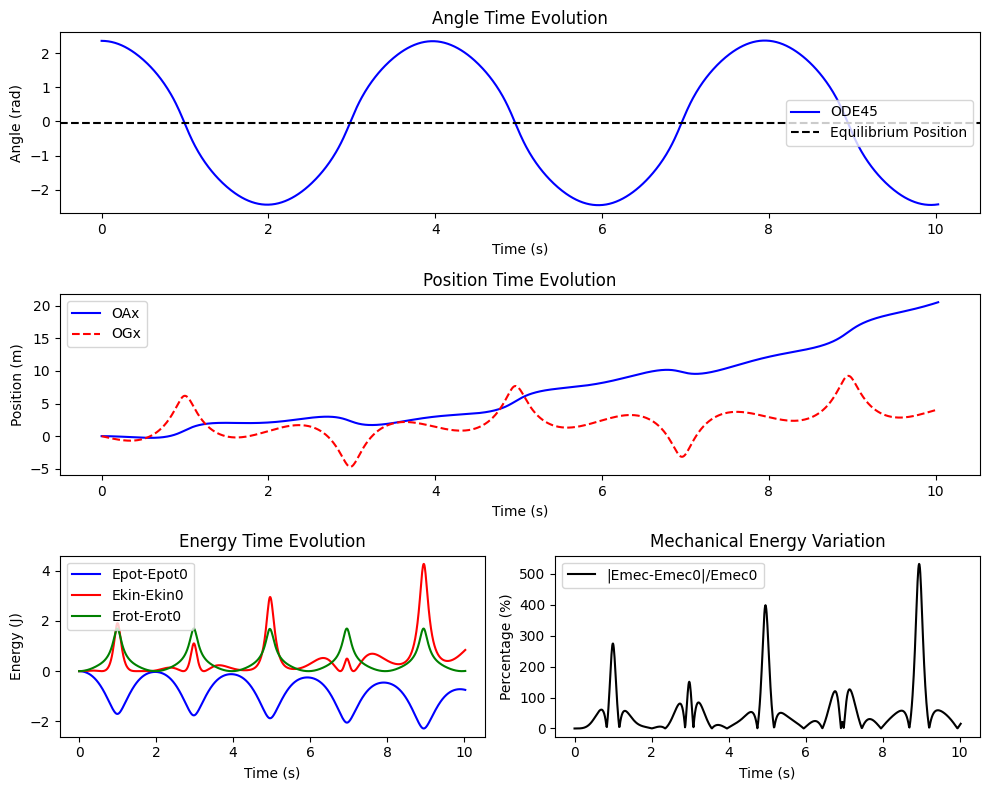

In [16]:
# Additional plots
# Angle time evolution
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t_eval, theta, '-b', label='ODE45')
plt.axhline(-alpha, color='k', linestyle='--', label='Equilibrium Position')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.title('Angle Time Evolution')
# Position time evolution
plt.subplot(3, 1, 2)
plt.plot(t_eval, xA, 'b-', label='OAx')
plt.plot(t_eval, vA, 'r--', label='OGx')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.title('Position Time Evolution')
# Energy time evolution
plt.subplot(3, 2, 5)
plt.plot(t_eval, Epot - Epot[0], 'b-', label='Epot-Epot0')
plt.plot(t_eval, Ekin - Ekin[0], 'r-', label='Ekin-Ekin0')
plt.plot(t_eval, Erot - Erot[0], 'g-', label='Erot-Erot0')
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.legend()
plt.title('Energy Time Evolution')
plt.subplot(3, 2, 6)
plt.plot(t_eval, abs(Emec - Emec[0]) / abs(Emec[0]) * 100, 'k-', label='|Emec-Emec0|/Emec0')
plt.xlabel('Time (s)')
plt.ylabel('Percentage (%)')
plt.legend()
plt.title('Mechanical Energy Variation')
plt.tight_layout()
plt.show()

## Animation
Finally, we create an animation to visualize the motion of the tyrolienne over time.

In [17]:
# Movie plot
# Interpolation of the trajectory for the movie (equidistant in t)
h = 2 # height of the cable [m]
def cable(x):
    return -np.tan(alpha) * x + h

APx =  2 * l * np.sin(theta)
APy = -2 * l * np.cos(theta)

OAx = xA * np.cos(alpha)
OAy = h - xA * np.sin(alpha)
OPx = OAx + APx
OPy = OAy + APy
OGx = OAx + APx / 2
OGy = OAy + APy / 2

# select every N points for the animation
N = 5
OAx = OAx[::N]
OAy = OAy[::N]
OPx = OPx[::N]
OPy = OPy[::N]
t_eval = t_eval[::N]

# Window measure
min_x = min(min(OPx),min(OAx)) - 0.5 * l
max_x = max(max(OPx),max(OAx)) + 0.5 * l
min_y = min(min(OPy),min(OAy)) - 0.5 * l
max_y = max(max(OPy),max(OAy)) + 0.5 * l

# Create the figure
fig, ax = plt.subplots()
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Tyrolienne Animation')
ax.set_aspect('equal')

# Initialize the plot elements
cable_line, = ax.plot([], [], '-', color=[0.5, 0.5, 0.5])
bar_line, = ax.plot([], [], 'k')
fixation_point, = ax.plot([], [], 'sk')
center_of_mass, = ax.plot([], [], 'xr')

# Update function for animation
def update(frame):
    cable_line.set_data([min_x, max_x], [cable(min_x), cable(max_x)])
    bar_line.set_data([OAx[frame], OPx[frame]], [OAy[frame], OPy[frame]])
    fixation_point.set_data([OAx[frame]], [OAy[frame]])
    # center_of_mass.set_data(OGx[frame], OGy[frame])
    ax.set_title(f't = {t_eval[frame]:.2f} s')
    return cable_line, bar_line, fixation_point, center_of_mass

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), blit=True)

# Save the animation as a GIF
ani.save('tyrolienne_animation.gif', writer='pillow', fps=30, dpi=80)

plt.close()

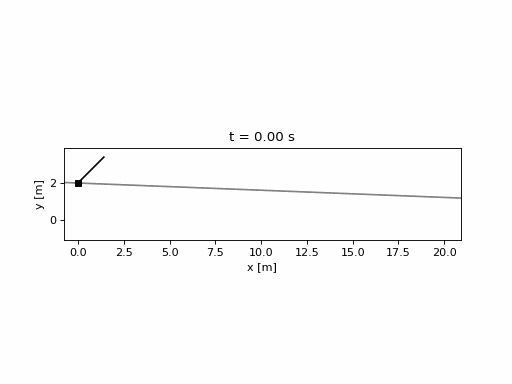

In [18]:
# Display the saved GIF
from IPython.display import Image, display

display(Image(filename='tyrolienne_animation.gif'))